In [53]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl
import pandas as pd
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted

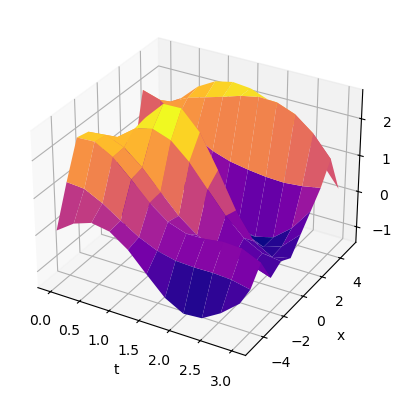

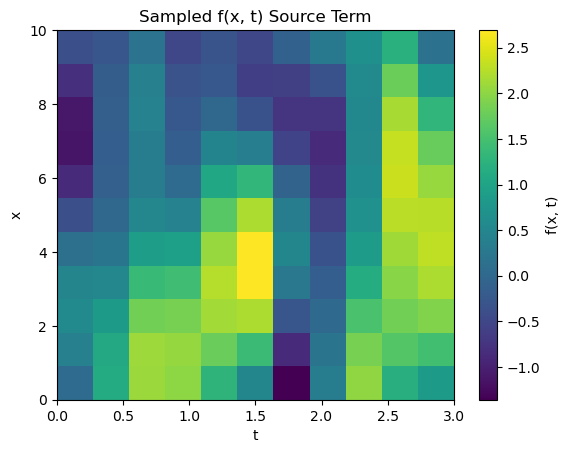

In [54]:
T = 3.0  # Time period
c = 1.0  # Wave speed
dx = 1  # Spatial step size
dt = 0.3  # Temporal step size
xmin = -5.0
xmax = 5.0
L = xmax - xmin
Nx = int((xmax-xmin)/dx) + 1  # Number of spatial points
Nt = int(T/dt) + 1  # Number of temporal points
x = np.linspace(xmin, xmax, Nx)  # Space grid
t = np.linspace(0, T, Nt)  # Time grid

if c * dt / dx > 1:
    raise ValueError("Stability condition violated: c*dt/dx must be <= 1")

# Define Gaussian Process Regressor for f(x, t)
X1,X2 = np.meshgrid(t, x, indexing='ij')
X_xt = np.column_stack([X1.ravel(), X2.ravel()])
kernel_xt = 1.0 * RBF(length_scale=1.0)
gpr_xt = GaussianProcessRegressor(kernel=kernel_xt, random_state=42)
f_xt_samples = gpr_xt.sample_y(X_xt, n_samples=10).reshape(Nt, Nx, 10)

# Plot a single f(x, t) source term
plt.figure()
ax = plt.axes(projection='3d')
cmap = mpl.colormaps['plasma']
ax.plot_surface(X1, X2, f_xt_samples[:,:,0], cmap=cmap)
plt.xlabel('t')
plt.ylabel('x')

plt.figure()
plt.imshow(f_xt_samples[:, :, 0], extent=[0, T, 0, L], origin='lower', aspect='auto')
plt.colorbar(label='f(x, t)')
plt.xlabel('t')
plt.ylabel('x')
plt.title('Sampled f(x, t) Source Term')
plt.show()

In [55]:

def sinc(x, c):
    threshold = 1e-8
    new_x = np.where(np.abs(x) < threshold, np.sign(x) * threshold, x)
    return np.sin(c*new_x)/(c*new_x)

#Solution to the second-order wave equation for given source terms
def solve_wave(f_xt):
    u0 = np.sinc(x)
    u = np.zeros((Nt, Nx))
    u[0, :] = u0
    u[1,:] = u[0,:]

    sigma = c * dt / dx
    if sigma > 1:
      raise ValueError("The scheme is unstable: sigma should be <= 1")
    #using finite difference method to solve the wave equation
    for n in range(1,Nt-1):
        for i in range(1,Nx-1):
            u[n+1, i] = (2 * u[n, i] - u[n-1, i] +
                     sigma**2 * (u[n, i+1] - 2 * u[n, i] + u[n, i-1])
                )+dt**2*f_xt[n,i]

        #Apply the boundary conditions (Dirichlet）
        u[n+1, 0] = 0
        u[n+1, -1] = 0

    return u


In [56]:
import matplotlib.animation as animation
def create_animation():
    # u = solve_wave(f_xt_samples[:, :, 0])  # Solution for f(x, t)
    u = solve_wave(np.zeros((Nt,Nx)))
    fig = plt.figure()
    plts = []             # get ready to populate this list the Line artists to be plotted
    # plt.hold("off")
    for ti in range(0,Nt):
        p, = plt.plot(x, u[ti,:], 'k')   # this is how you'd plot a single line...
        plts.append( [p] )           # ... but save the line artist for the animation
    ani = animation.ArtistAnimation(fig, plts, interval=50, repeat_delay=3000)   # run the animation
    ani.save('wave2.mp4')    # optionally save it to a file

    plt.show()

# create_animation()

In [57]:
#kernel model definition
def Kt(X, Y, col, K):
    l = K.get_params()['length_scale']
    coeff = - (1/l**2) * (X[:,col:col+1] - Y[:, col:col+1].T)
    return coeff * K(X, Y)

def Ktt(X, Y, col, K):
    l = K.get_params()['length_scale']
    coeff = (1/l**2) * ((1/l**2) * (X[:,col:col+1] - Y[:, col:col+1].T) ** 2 -1)
    return coeff * K(X,Y)

class KernelModel(BaseEstimator, RegressorMixin):
    def __init__(self, nugget=1e-7, length_scale=1, partial_derivative_order=0, partial_derivative_column=0):
        self.length_scale = length_scale
        self.nugget = nugget
        self.partial_derivative_order = partial_derivative_order
        self.partial_derivative_column = partial_derivative_column
    def fit(self, X, y):
        # Check that X and y have correct shape
        X, y = check_X_y(X, y)
        self.X_ = X
        self.y_ = y
        self.K = RBF(length_scale=self.length_scale)
        UXX = self.K(self.X_, self.X_)
        UXX_nugget = (UXX + self.nugget ** 2 * np.eye(self.X_.shape[0]))
        self.UXX_inv_y = np.linalg.solve(UXX_nugget, self.y_)
        return self

    def predict(self, X):

        # Check if fit has been called
        check_is_fitted(self)
        # Input validation
        X = check_array(X)

        if(self.partial_derivative_order == 0):
            UxX = self.K(X, self.X_)

        elif(self.partial_derivative_order == 1):
            UxX = Kt(X, self.X_, self.partial_derivative_column, self.K)

        elif(self.partial_derivative_order == 2):
            UxX = Ktt(X, self.X_, self.partial_derivative_column, self.K)
        return UxX @ self.UXX_inv_y

    def set_params(self, **params):
        if not params:
            return self

        for key, value in params.items():
            if hasattr(self, key):
                setattr(self, key, value)

        return self

In [58]:
training_data = []
T, X = np.meshgrid(t, x, indexing='ij')
grid_points = np.c_[T.ravel(), X.ravel()]

np.random.seed(42)

for i in range(10):
    u = solve_wave(f_xt_samples[:, :, i])  # Solution for f(x, t)
    u = u.reshape(-1,1)
    u_std = np.std(u)
    noise = np.random.normal(0, 0.05 * u_std, Nt*Nx)
    u_perturbed = u + noise.reshape(-1,1)

    training_data.append(np.column_stack((grid_points, u_perturbed, u)))


In [59]:
#u_tt - c^2 u_xx = f(x,t)
#aim learn P(s) = f(x,t)
#s = ?   s= [X,u_tt,u_xx]
#  s^{1} ==  [s_{1}^{1} = [0,0,u_tt(0,0),u_xx(0,0)]  ...... s_{2500}^{1}]
# S = [s^{1} ......s^{10}] : 10 sorucing term
#
S_array = []
best_params = []
cv_results = []
l_range = np.arange(0.01, 2, 0.01)
eta = 5e-8
i = 0
for data in training_data:
    grid_points = data[:,0:2]
    u_sample = data[:, 3]

    cv = ShuffleSplit(n_splits=10, random_state=0)
    grid_search = GridSearchCV(estimator=KernelModel(eta, 1),
                               param_grid={'length_scale': l_range},
                               cv=cv,
                               scoring='neg_mean_squared_error')

    # Fit the GridSearchCV
    grid_search.fit(grid_points, u_sample)
    km = grid_search.best_estimator_
    s0 = grid_points
    s1 = km.set_params(partial_derivative_order=2,partial_derivative_column=0).predict(grid_points)
    s2 = km.set_params(partial_derivative_order=2,partial_derivative_column=1).predict(grid_points)
    Si = np.column_stack((s0, s1, s2))
    S_array.append(Si)
    best_params.append(grid_search.best_params_)
    cv_results.append(grid_search.cv_results_)
    print(i, grid_search.best_params_)
    i += 1

0 {'length_scale': 1.87}
1 {'length_scale': 1.81}
2 {'length_scale': 1.41}
3 {'length_scale': 1.8}
4 {'length_scale': 1.17}
5 {'length_scale': 1.53}
6 {'length_scale': 1.3800000000000001}
7 {'length_scale': 0.96}
8 {'length_scale': 1.68}
9 {'length_scale': 1.74}


In [60]:
S = np.vstack(S_array)

In [73]:
P_l_range = np.arange(0.01, 15, 0.1)
P_eta = 1e-6

y_list = []
for i in range(10):
  f_i = f_xt_samples[:,:,i].reshape(-1)
  y_list.append(f_i)
y = np.concatenate(y_list)
X = S

X_test = S[0:Nt*Nx,:]
y_test = y[0:Nt*Nx]

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('km', KernelModel(P_eta, 1))
])

cv = ShuffleSplit(n_splits=10, random_state=0)
grid_search = GridSearchCV(pipeline,
                            param_grid={'km__length_scale': P_l_range},
                            cv=cv,
                            scoring='neg_mean_squared_error'
                            )

# Fit the GridSearchCV
grid_search.fit(X, y)
km = grid_search.best_estimator_
P_star = km.predict(X_test)

-0.25204389685345907
{'km__length_scale': 14.110000000000001}


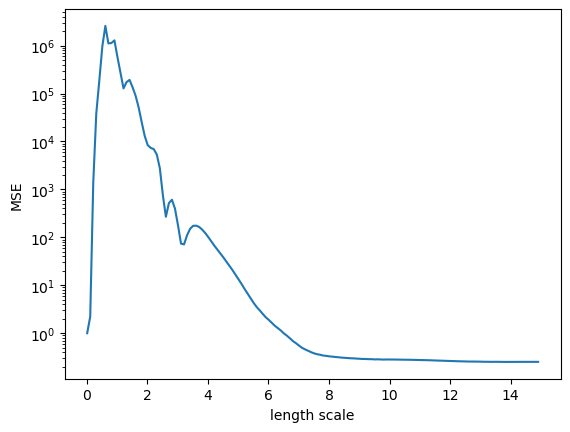

In [74]:
df = pd.DataFrame(grid_search.cv_results_)
plt.figure()
plt.semilogy(P_l_range, -df['mean_test_score'])
plt.xlabel('length scale')
plt.ylabel('MSE')
print(grid_search.best_score_)
print(grid_search.best_params_)

In [75]:
mean_squared_error(P_star, y_test)

0.2701211453601973

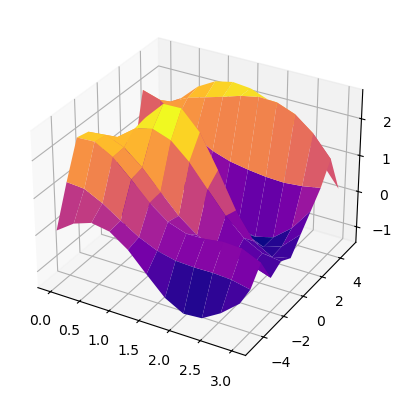

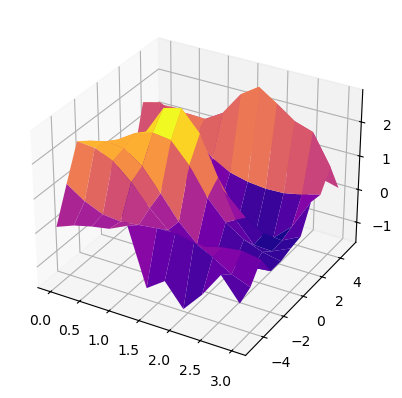

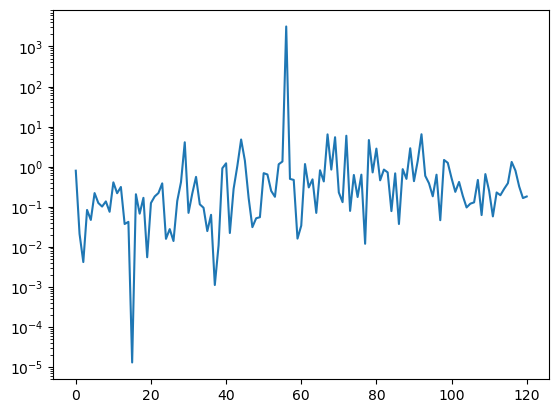

In [93]:
X1,X2 = np.meshgrid(t, x, indexing='ij')

plt.figure()
ax = plt.axes(projection='3d')
# Plot the solution
cmap = mpl.colormaps['plasma']
ax.plot_surface(X1, X2, f_xt_samples[:,:,0], cmap=cmap)

plt.figure()
ax = plt.axes(projection='3d')
# Plot the solution
cmap = mpl.colormaps['plasma']
P_star = km.predict(X_test)
ax.plot_surface(X1, X2, P_star.reshape((Nt,Nx)), cmap=cmap)

plt.figure()
P_star = km.predict(X_test)
plt.semilogy(np.abs(P_star-y_test)/np.abs(y_test))